In [1]:
import numpy as np
from gridworld import GridWorld

import matplotlib.pyplot as plt

#import irl.linear_irl as linear_irl
#import irl.mdp.gridworld as gridworld

In [2]:
def print_policy(policy_matrix):
    '''Print the policy using specific symbol.

    * terminal state
    ^ > v < up, right, down, left
    # obstacle
    '''
    counter = 0
    shape = policy_matrix.shape
    policy_string = ""
    for row in range(shape[0]):
        for col in range(shape[1]):
            if(policy_matrix[row,col] == -1): policy_string += " *  "
            elif(policy_matrix[row,col] == 0): policy_string += " ^  "
            elif(policy_matrix[row,col] == 1): policy_string += " >  "
            elif(policy_matrix[row,col] == 2): policy_string += " v  "
            elif(policy_matrix[row,col] == 3): policy_string += " <  "
            elif(np.isnan(policy_matrix[row,col])): policy_string += " #  "
            counter += 1
        policy_string += '\n'
    print(policy_string)

def get_return(state_list, gamma):
    '''Get the return for a list of action-state values.

    @return get the Return
    '''
    counter = 0
    return_value = 0
    for visit in state_list:
        reward = visit[2]
        return_value += reward * np.power(gamma, counter)
        counter += 1
    return return_value

def update_policy(episode_list, policy_matrix, state_action_matrix):
    '''Update a policy making it greedy in respect of the state-action matrix.

    @return the updated policy
    '''
    for visit in episode_list:
        observation = visit[0]
        col = observation[1] + (observation[0]*4)
        if(policy_matrix[observation[0], observation[1]] != -1):
            policy_matrix[observation[0], observation[1]] = \
                np.argmax(state_action_matrix[:,col])
    return policy_matrix

In [17]:
from cvxopt import matrix, solvers

def irl(n_states, n_actions, transition_probability, policy, discount, Rmax,
        l1):
    """
    Find a reward function with inverse RL as described in Ng & Russell, 2000.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    policy: Vector mapping state ints to action ints. Shape (N,).
    discount: Discount factor. float.
    Rmax: Maximum reward. float.
    l1: l1 regularisation. float.
    -> Reward vector
    """

    A = set(range(n_actions))  # Set of actions to help manage reordering
                               # actions.
    # The transition policy convention is different here to the rest of the code
    # for legacy reasons; here, we reorder axes to fix this. We expect the
    # new probabilities to be of the shape (A, N, N).
    transition_probability = np.transpose(transition_probability, (1, 0, 2))

    def T(a, s):
        """
        Shorthand for a dot product used a lot in the LP formulation.
        """

        return np.dot(transition_probability[policy[s], s] -
                      transition_probability[a, s],
                      np.linalg.inv(np.eye(n_states) -
                        discount*transition_probability[policy[s]]))

    # This entire function just computes the block matrices used for the LP
    # formulation of IRL.

    # Minimise c . x.
    c = -np.hstack([np.zeros(n_states), np.ones(n_states),
                    -l1*np.ones(n_states)])
    zero_stack1 = np.zeros((n_states*(n_actions-1), n_states))
    T_stack = np.vstack([
        -T(a, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack2 = np.eye(n_states)
    zero_stack2 = np.zeros((n_states, n_states))

    D_left = np.vstack([T_stack, T_stack, -I_stack2, I_stack2])
    D_middle = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
    D_right = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])

    D = np.hstack([D_left, D_middle, D_right])
    b = np.zeros((n_states*(n_actions-1)*2 + 2*n_states, 1))
    bounds = np.array([(None, None)]*2*n_states + [(-Rmax, Rmax)]*n_states)

    # We still need to bound R. To do this, we just add
    # -I R <= Rmax 1
    # I R <= Rmax 1
    # So to D we need to add -I and I, and to b we need to add Rmax 1 and Rmax 1
    D_bounds = np.hstack([
        np.vstack([
            -np.eye(n_states),
            np.eye(n_states)]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))])])
    b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
    D = np.vstack((D, D_bounds))
    b = np.vstack((b, b_bounds))
    A_ub = matrix(D)
    b = matrix(b)
    c = matrix(c)
    results = solvers.lp(c, A_ub, b)
    r = np.asarray(results["x"][:n_states], dtype=np.double)

    return r.reshape((n_states,))

In [5]:
env = GridWorld(5, 5)

#Define the state matrix
state_matrix = np.zeros((5,5))
state_matrix[0, 4] = 1
print("State Matrix:")
print(state_matrix)

#Define the reward matrix
reward_matrix = np.full((5,5), 0)
reward_matrix[0, 4] = 1
print("Reward Matrix:")
print(reward_matrix)

#Define the transition matrix
transition_matrix = np.array([[0.7, 0.1, 0.1, 0.1],
                              [0.1, 0.7, 0.1, 0.1],
                              [0.1, 0.1, 0.7, 0.1],
                              [0.1, 0.1, 0.1, 0.7]])

#Random policy
policy_matrix = np.random.randint(low=0, high=4, size=(5, 5)).astype(np.float32)
policy_matrix[0,4] = -1

#Set the matrices in the world
env.setStateMatrix(state_matrix)
env.setRewardMatrix(reward_matrix)
env.setTransitionMatrix(transition_matrix)

state_action_matrix = np.random.random_sample((4,25)) # Q
#init with 1.0e-10 to avoid division by zero
running_mean_matrix = np.full((4,25), 1.0e-10)
gamma = 0.9
tot_epoch = 30000
print_epoch = 1000

for epoch in range(tot_epoch):
    #Starting a new episode
    episode_list = list()
    #Reset and return the first observation and reward
    observation = env.reset(exploring_starts=False)

    is_starting = True
    for _ in range(1000):
        #Take the action from the action matrix
        action = policy_matrix[observation[0], observation[1]]
        #If the episode just started then it is
            #necessary to choose a random action (exploring starts)
        if(is_starting):
            action = np.random.randint(0, 4)
            is_starting = False
        #Move one step in the environment and get obs and reward
        new_observation, reward, done = env.step(action)
        #Append the visit in the episode list
        episode_list.append((observation, action, reward))
        observation = new_observation
        
        if done: break
            
        #The episode is finished, now estimating the utilities
        counter = 0
        #Checkup to identify if it is the first visit to a state
        checkup_matrix = np.zeros((4,25))
        #This cycle is the implementation of First-Visit MC.

        for visit in episode_list:
            observation = visit[0]
            action = visit[1]
            col = int(observation[1] + (observation[0]*4))
            row = int(action)
            if(checkup_matrix[row, col] == 0):
                return_value = get_return(episode_list[counter:], gamma)
                running_mean_matrix[row, col] += 1
                state_action_matrix[row, col] += return_value
                checkup_matrix[row, col] = 1
            counter += 1
        #Policy Update
        policy_matrix = update_policy(episode_list,
                                      policy_matrix,
                                      state_action_matrix/running_mean_matrix)
        final_policy = policy_matrix

    if(epoch % print_epoch == 0):
        print("------>",epoch % print_epoch)
        print("State-Action matrix after " + str(epoch+1) + " iterations:")
        print(state_action_matrix / running_mean_matrix)
        print("Policy matrix after " + str(epoch+1) + " iterations:")
        print(policy_matrix)
        print("Policy Directions")
        print_policy(policy_matrix)


#Time to check the utility matrix obtained
print("Utility matrix after " + str(tot_epoch) + " iterations:")
print(state_action_matrix / running_mean_matrix)
print("Final policy:")
print(final_policy)
        
print("-------END--------")

State Matrix:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward Matrix:
[[0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
('------>', 0)
State-Action matrix after 1 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  5.15356031e-02 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  4.99110572e-02 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+

('------>', 0)
State-Action matrix after 5001 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  1.34722533e-06 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  1.34719371e-06 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+09
  3.39872318e+09]
 [3.87952129e+09 8.98603849e+09 9.43289803e+09 6.16781209e+09
  1.49745824e+09 2.68955400e+09 4.39031180e+09 2.02602321e+09
  1.80411385e+09 7.46466182e+09 4.7011

('------>', 0)
State-Action matrix after 10001 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  6.68807142e-07 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  6.68745728e-07 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+09
  3.39872318e+09]
 [3.87952129e+09 8.98603849e+09 9.43289803e+09 6.16781209e+09
  1.49745824e+09 2.68955400e+09 4.39031180e+09 2.02602321e+09
  1.80411385e+09 7.46466182e+09 4.701

('------>', 0)
State-Action matrix after 15001 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  4.45263041e-07 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  4.45261069e-07 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+09
  3.39872318e+09]
 [3.87952129e+09 8.98603849e+09 9.43289803e+09 6.16781209e+09
  1.49745824e+09 2.68955400e+09 4.39031180e+09 2.02602321e+09
  1.80411385e+09 7.46466182e+09 4.701

('------>', 0)
State-Action matrix after 20001 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  3.33830159e-07 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  3.33825313e-07 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+09
  3.39872318e+09]
 [3.87952129e+09 8.98603849e+09 9.43289803e+09 6.16781209e+09
  1.49745824e+09 2.68955400e+09 4.39031180e+09 2.02602321e+09
  1.80411385e+09 7.46466182e+09 4.701

('------>', 0)
State-Action matrix after 25001 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  2.67821168e-07 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  2.67816942e-07 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+09
  3.39872318e+09]
 [3.87952129e+09 8.98603849e+09 9.43289803e+09 6.16781209e+09
  1.49745824e+09 2.68955400e+09 4.39031180e+09 2.02602321e+09
  1.80411385e+09 7.46466182e+09 4.701

Utility matrix after 30000 iterations:
[[4.55408036e+09 7.60991806e+09 6.33277424e+09 9.79719295e+09
  8.91756230e+09 9.35608833e+09 9.55560315e+09 7.52155786e+09
  4.69911355e+09 8.87673681e+09 1.63316162e+09 1.92672758e+09
  3.27422497e+09 8.22512943e+08 4.87875437e+08 6.56015380e+09
  2.22872427e-07 3.40907632e+09 2.72882925e+09 4.98384438e+09
  7.08536274e+08 8.90264003e+09 9.98275297e+09 4.07750609e+09
  7.22995027e+09]
 [1.72260627e+09 8.42912606e+09 3.68881525e+09 9.90432771e+09
  3.91744722e+08 4.58484470e+09 4.97847038e+09 5.53020289e+09
  8.44895595e+09 4.80810264e+09 3.22914720e+08 4.17438886e+09
  4.42067289e+09 1.51770163e+09 2.39381608e+09 1.11632766e+09
  2.22867547e-07 2.70638014e+09 4.14100198e+09 2.80112579e+09
  8.47980760e+09 5.33867500e+09 1.55079760e+09 7.41016628e+09
  3.39872318e+09]
 [3.87952129e+09 8.98603849e+09 9.43289803e+09 6.16781209e+09
  1.49745824e+09 2.68955400e+09 4.39031180e+09 2.02602321e+09
  1.80411385e+09 7.46466182e+09 4.70118938e+09 5.29741760

In [6]:
state_value_matrix = state_action_matrix.max(axis=0)
state_value_matrix

array([0.79958995, 0.89860385, 0.9432898 , 0.99043277, 0.89175623,
       0.9580271 , 0.95556031, 0.75215579, 0.84489559, 0.88767368,
       0.47011894, 0.99583297, 0.72779957, 0.52901511, 0.41019291,
       0.65601538, 0.72149844, 0.42831422, 0.73409815, 0.49838444,
       0.9341168 , 0.92068446, 0.9982753 , 0.74101663, 0.89993566])

In [12]:
final_policy[final_policy==-1] = 0
final_policy_list = final_policy.reshape(-1).astype(int)
final_policy,final_policy_list

(array([[2., 3., 0., 1., 0.],
        [2., 1., 0., 2., 3.],
        [3., 3., 0., 3., 1.],
        [3., 2., 3., 3., 0.],
        [0., 2., 0., 2., 3.]], dtype=float32),
 array([2, 3, 0, 1, 0, 2, 1, 0, 2, 3, 3, 3, 0, 3, 1, 3, 2, 3, 3, 0, 0, 2,
        0, 2, 3]))

## Random State Transition Matrix

In [13]:
random_state_transition_matrix = np.random.rand(25,4,25)
random_state_transition_matrix = random_state_transition_matrix/ \
                                random_state_transition_matrix.sum(axis=1)[:,None]
random_state_transition_matrix.shape

(25, 4, 25)

## With a handcrafted State Transition Matrix

In [14]:
fixed_state_transition_matrix = np.load("gw_transition_probability.npy")
fixed_state_transition_matrix.shape

(25, 4, 25)

In [20]:
r_random = irl(n_states=25,n_actions=4,transition_probability=random_state_transition_matrix,\
    policy=final_policy_list,discount=0.2,Rmax=1,l1=5)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.7403e+01  5e+02  2e+00  2e+00  1e+00
 1:  2.1354e+00 -4.5484e+00  3e+01  2e-01  2e-01  4e-01
 2:  4.3318e-02 -1.9053e-01  9e-01  8e-03  7e-03  1e-02
 3:  4.3427e-04 -1.8942e-03  9e-03  8e-05  7e-05  1e-04
 4:  4.3424e-06 -1.8940e-05  9e-05  8e-07  7e-07  1e-06
 5:  4.3424e-08 -1.8940e-07  9e-07  8e-09  7e-09  1e-08
 6:  4.3424e-10 -1.8940e-09  9e-09  8e-11  7e-11  1e-10
Optimal solution found.


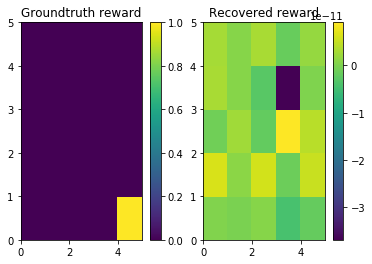

In [24]:
plt.subplot(1, 2, 1)
plt.pcolor(reward_matrix)
plt.colorbar()
plt.title("Groundtruth reward")
plt.subplot(1, 2, 2)
plt.pcolor(r_random.reshape((5, 5)))
plt.colorbar()
plt.title("Recovered reward")
plt.show()

In [40]:
policy

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]

In [45]:
r_fixed = irl(n_states=25,n_actions=4,transition_probability=fixed_state_transition_matrix,\
    policy=final_policy_list,discount=0.2,Rmax=1,l1=5)
r_fixed

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.0906e+01  5e+02  2e+00  1e+00  1e+00
 1:  1.8811e+00 -2.9890e+00  2e+01  2e-01  1e-01  3e-01
 2:  4.6237e-02 -4.6574e-02  4e-01  4e-03  2e-03  1e-02
 3:  4.6117e-04 -4.6432e-04  4e-03  4e-05  2e-05  1e-04
 4:  4.6116e-06 -4.6430e-06  4e-05  4e-07  2e-07  1e-06
 5:  4.6116e-08 -4.6430e-08  4e-07  4e-09  2e-09  1e-08
 6:  4.6116e-10 -4.6430e-10  4e-09  4e-11  2e-11  1e-10
Optimal solution found.


array([ 1.28555197e-12,  1.52417054e-13, -3.92255468e-12,  5.97669658e-13,
       -7.82074483e-16,  1.86377488e-12,  7.18614662e-13,  4.30147050e-13,
        2.40435669e-12, -4.14775544e-12, -5.70635990e-14,  1.43368405e-12,
       -2.91557837e-13,  1.36537830e-12, -3.59928473e-12,  6.37742266e-13,
       -1.82403056e-12, -2.57291737e-12, -2.26972656e-12,  3.26391815e-12,
        7.99347020e-13,  1.34941538e-12,  9.90519237e-13,  5.69069747e-13,
       -2.74919465e-12])

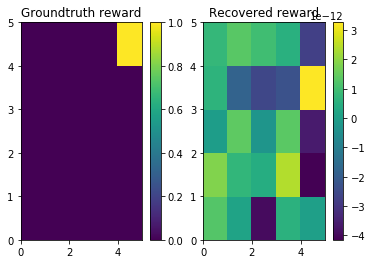

In [46]:
plt.subplot(1, 2, 1)
plt.pcolor(ground_r.reshape(5,5))
plt.colorbar()
plt.title("Groundtruth reward")
plt.subplot(1, 2, 2)
plt.pcolor(r_fixed.reshape((5, 5)))
plt.colorbar()
plt.title("Recovered reward")
plt.show()

In [22]:
reward_matrix

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [36]:
#n_states, n_actions, transition_probability, policy, discount, Rmax,l1
import irl.linear_irl as linear_irl
import irl.mdp.gridworld as gridworld

grid_size = 5
discount = 0.2
"""
Run linear programming inverse reinforcement learning on the gridworld MDP.

Plots the reward function.

grid_size: Grid size. int.
discount: MDP discount factor. float.
"""

wind = 0.3
trajectory_length = 3*grid_size

gw = gridworld.Gridworld(grid_size, wind, discount)
ground_r = np.array([gw.reward(s) for s in range(gw.n_states)])

gw.n_states, gw.n_actions, gw.transition_probability.shape,final_policy_list, gw.discount,ground_r.reshape(5,5)

(25,
 4,
 (25, 4, 25),
 array([2, 3, 0, 1, 0, 2, 1, 0, 2, 3, 3, 3, 0, 3, 1, 3, 2, 3, 3, 0, 0, 2,
        0, 2, 3]),
 0.2,
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1]]))

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.5658e+01  5e+02  2e+00  2e+00  1e+00
 1:  2.7811e+00 -4.4019e+00  3e+01  3e-01  2e-01  4e-01
 2:  1.4504e-01 -1.4696e-01  1e+00  1e-02  8e-03  2e-02
 3:  1.4461e-03 -1.4603e-03  1e-02  1e-04  8e-05  2e-04
 4:  1.4459e-05 -1.4601e-05  1e-04  1e-06  8e-07  2e-06
 5:  1.4459e-07 -1.4601e-07  1e-06  1e-08  8e-09  2e-08
 6:  1.4459e-09 -1.4601e-09  1e-08  1e-10  8e-11  2e-10
Optimal solution found.
(25,)
<bound method Gridworld.optimal_policy_deterministic of <irl.mdp.gridworld.Gridworld object at 0x7f3735b9b3d0>>
[[1 1 1 1 1]
 [0 1 1 1 1]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]]


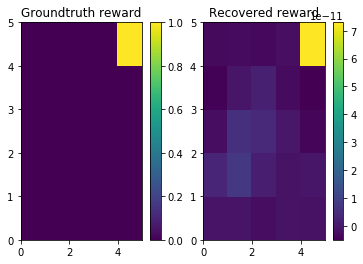

array([-7.88503854e-13, -7.96617345e-13, -2.37743936e-12, -1.30746182e-12,
       -1.39291384e-12,  3.21061396e-12,  7.50621592e-12,  1.40891975e-12,
       -1.26874270e-12, -4.66048946e-13, -2.52667497e-12,  5.72718690e-12,
        3.91156687e-12, -3.45448855e-13, -3.99026666e-12, -4.51729942e-12,
       -4.93376505e-13,  1.96339663e-12, -2.62965848e-12, -5.00165771e-12,
       -3.02604337e-12, -2.62406856e-12, -3.37511014e-12, -2.03493835e-12,
        7.29922970e-11])

In [47]:
ground_r = np.array([gw.reward(s) for s in range(gw.n_states)])

policy = [gw.optimal_policy_deterministic(s) for s in range(gw.n_states)]
print(policy)
final_policy_list = list(final_policy.reshape(-1).astype(int))
r = linear_irl.irl(gw.n_states, gw.n_actions, gw.transition_probability,policy, gw.discount, 1, 5)
#r = linear_irl.irl(gw.n_states, gw.n_actions, gw.transition_probability,final_policy_list, gw.discount, 1, 5)
print(r.shape)
print(gw.optimal_policy_deterministic)
print(np.array(policy).reshape(5,5))

plt.subplot(1, 2, 1)
plt.pcolor(ground_r.reshape((grid_size, grid_size)))
plt.colorbar()
plt.title("Groundtruth reward")
plt.subplot(1, 2, 2)
plt.pcolor(r.reshape((grid_size, grid_size)))
plt.colorbar()
plt.title("Recovered reward")
plt.show()


In [48]:
reward_matrix

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [50]:
np.flip(reward_matrix,0)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])